In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from z_score_outlier_remover import ZScoreOutlierRemover
from iqr_outlier_remover import IQROutlierRemover
from determine_skewness import choose_outlier_method

ImportError: cannot import name 'choose_outlier_method' from 'determine_skewness' (c:\Users\Chris\Documents\coding_projects\king-county-price-prediction\determine_skewness.py)

In [ ]:
pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_csv('data/kc_house_data.csv')

In [7]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Column Descriptions:

    id - unique identified for a house
    date - date the house was sold
    price - target variable
    bedrooms - # of Bedrooms/House
    bathrooms - # of bathrooms/bedrooms
    sqft_living - footage of the home
    sqft_lot - footage of the lot
    floors - floors (levels) in house
    waterfront - House which has a view to a waterfront
    view - Has been viewed
    condition - How good the condition is ( Overall )
    grade - overall grade given to the housing unit, based on King County grading system
    sqft_above - square footage of house apart from basement
    sqft_basement - square footage of the basement
    yr_built - Built Year
    yr_renovated - Year when house was renovated
    zipcode - zip
    lat - Latitude coordinate
    long - Longitude coordinate
    sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
    sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


In [8]:
# no null values in the dataset
# date has strings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [9]:
# temporarily dropping date to look at correlations
pd.DataFrame(df.drop(columns='date').corr()['price']).sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138
view,0.397293
sqft_basement,0.323816
bedrooms,0.308350
lat,0.307003


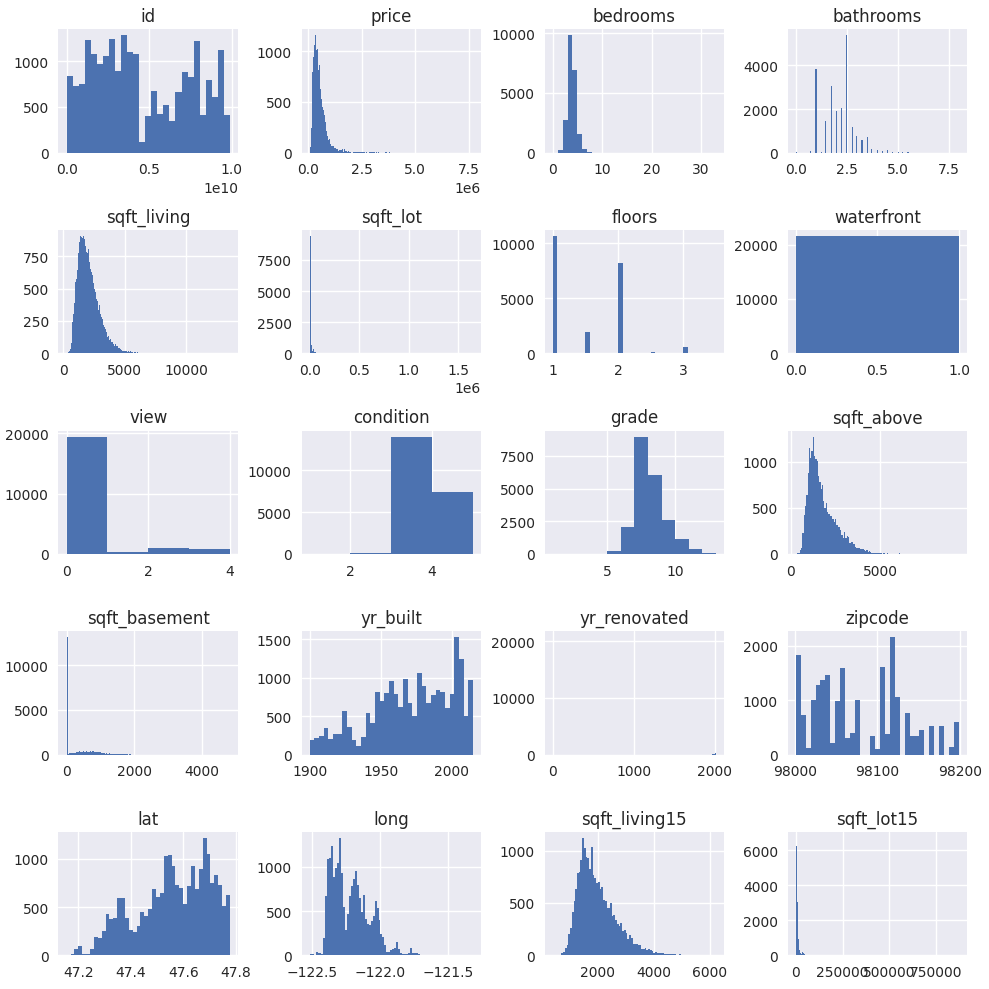

In [10]:
with plt.style.context('seaborn-v0_8'):
    df.drop(columns='date').hist(figsize=(10,10), bins='auto')
    plt.tight_layout();

In [11]:
df.drop(columns='date').describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### To do:
- make sure no duplicates in id, then drop
- look into bedrooms, has large values (33)
- look into bathrooms, has large values (8)
- look into sq ft living (largest is 13,540 sq ft)
- look into sq ft lot (1.65 x 10^6)
- create is_renovated from yr_renovated, then drop yr_renovated
- maybe can build some new col with zipcode?

In [12]:
# check for duplicates in id
df['id'].nunique() == df.shape[0]
df.drop(columns='id', inplace=True)

In [13]:
# some of the bedrooms have large values. Could be outliers or misentries.
df['bedrooms'].value_counts().sort_index()

bedrooms
0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

In [ ]:
def calc_IQR(df, col):
    """
    Calculate the Interquartile Range (IQR) for a given column in a DataFrame.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print(f"{col} - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    return Q1, Q3, IQR

In [15]:
def calc_zscore(df, col):
    """
    Calculate the Z-score for a given column in a DataFrame.
    """
    mean = df[col].mean()
    std = df[col].std()
    
    print(f"{col} - Mean: {mean}, Std: {std}")
    return mean, std

In [16]:
calc_zscore(df, 'bedrooms')

bedrooms - Mean: 3.37084162309721, Std: 0.9300618311474514


(np.float64(3.37084162309721), np.float64(0.9300618311474514))

In [14]:
calc_IQR(df, 'bedrooms')

bedrooms - Q1: 3.0, Q3: 4.0, IQR: 1.0


(np.float64(3.0), np.float64(4.0), np.float64(1.0))

In [21]:
# create a new column to indicate if the house has been renovated
# if yr_renovated is greater than 0, then the house has been renovated
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns='yr_renovated', inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [24]:
X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17290, 19), (4323, 19), (17290,), (4323,))